In [1]:
import Load_Downsize_SaveAsH5 as cvt
import numpy as np
import h5py
import pandas as pd
import tensorflow as tf
from keras.losses import categorical_crossentropy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


### partial data with Top as target

In [2]:
filePath = './ourdata/'
features = ['j_index','j1_phirel','j1_etarel','j1_phirot','j1_etarot','j1_deltaR','j1_pdgid','j1_pt','j1_ptrel','j1_erel'] 
labels = ['j_g','j_q','j_w','j_z','j_t']
#ratio=[.25,.25,.25,.25,1]
size=15000 # number of jets for each tagger
seed=42 # random state
N_par = 20 # number of particles in one jet

In [6]:
cvt.LoadTransSave(filePath,features, labels,size=size,seed=seed)

100%|███████████████████████████████████████████████████████████████████████████| 75000/75000 [09:21<00:00, 133.66it/s]


### prepare data

In [3]:
cols = dict(zip(features+['constituents_index'], [i for i in range(len(features)+1)]))

features_list = ['j1_ptrel','j1_etarot','j1_phirot','j1_phirel','j1_etarel','j1_erel','j1_deltaR','j1_pdgid']

def h5_to_data(h5path):
    Data = {'mask':[], 'points':[], 'features':[],'label':[]}
    f = h5py.File(h5path,'r')
    raw_data = np.array([f[col][()] for col in cols])
    label_arr = f['label'][()]
    raw_data = raw_data.transpose((1,0))
    mask, features, points = np.zeros((N_par,1)), np.zeros((N_par,len(features_list))), np.zeros((N_par,2)) # prepare constituents list
    for i in range(len(raw_data)):
        cIndex = int(raw_data[i][cols['constituents_index']])
        if cIndex >= N_par:                                               # skip when excess N_par particles
            continue
        
        mask[cIndex] = [1]                                             # no mask for now
        points[cIndex] = np.array([raw_data[i][cols['j1_etarel']],raw_data[i][cols['j1_phirel']]])
        features[cIndex] = np.array([raw_data[i][cols[feat]] for feat in features_list])
                
        if i < len(raw_data)-1:
            if raw_data[i][cols['j_index']] != raw_data[i+1][cols['j_index']] : # save the jet before switch to another
                Data['mask'].append(mask)
                Data['points'].append(points)
                Data['features'].append(features)
                Data['label'].append(label_arr[i])
                mask, features, points = np.zeros((N_par,1)), np.zeros((N_par,len(features_list))), np.zeros((N_par,2))  
    f.close()
    y = Data.pop('label')
    return Data, y

def merging(gg,qq):
    total={}
    total['mask']=gg["mask"]+qq["mask"]
    total['features']=gg["features"]+qq["features"]
    total['points']=gg['points']+qq['points']
    return total


def separatedata(Data,y,rateval,ratetest,seed):
    features_train, features_test, features_val={},{},{}
    from sklearn.model_selection import train_test_split
    mask = Data["mask"]
    features = Data["features"]
    points = Data["points"]
    X_ind = [i for i in range(len(y))]
    X_train, X_ind, y_train, y_ind = train_test_split(X_ind, y, test_size=rateval+ratetest, random_state=seed)
    X_val, X_test, y_val, y_test = train_test_split(X_ind, y_ind, test_size=(rateval/(rateval+ratetest)), random_state=seed)
    
    features_train['mask']=np.array([mask[i] for i in X_train])
    features_train['features']=np.array([features[i] for i in X_train])
    features_train['points']=np.array([points[i] for i in X_train])
    
    features_test['mask']=np.array([mask[i] for i in X_test])
    features_test['features']=np.array([features[i] for i in X_test])
    features_test['points']=np.array([points[i] for i in X_test])
    
    features_val['mask']=np.array([mask[i] for i in X_val])
    features_val['features']=np.array([features[i] for i in X_val])
    features_val['points']=np.array([points[i] for i in X_val])
    
    return features_train, features_val, features_test,np.array(y_train), np.array(y_val), np.array(y_test)

check shape:  (20, 1) (20, 2) (20, 8)


In [4]:
h5Path = "ourdata/data_15000jets_5labels.h5"
Data,y = h5_to_data(h5Path)
print("check shape: ",Data['mask'][0].shape,Data['points'][0].shape,Data['features'][0].shape)

check shape:  (20, 1) (20, 2) (20, 8)


In [6]:
X_train, X_val, X_test, y_train, y_val, y_test = separatedata(Data,y,0.25,0.25,seed)

In [7]:
import sys
sys.path.insert(0,'models')
from tf_keras_model import get_particle_net_lite, get_particle_net

In [8]:
input_shapes={'points': X_train['points'][0].shape, 'features': X_train['features'][0].shape, 'mask': X_train['mask'][0].shape}
num_classes = 5
model = get_particle_net(num_classes, input_shapes)
input_shapes

{'points': (20, 2), 'features': (20, 8), 'mask': (20, 1)}

In [9]:
batch_size = 1024
epochs = 100

In [10]:
opt = tf.keras.optimizers.Adam(lr=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "ParticleNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mask (InputLayer)               [(None, 20, 1)]      0                                            
__________________________________________________________________________________________________
tf_op_layer_NotEqual (TensorFlo [(None, 20, 1)]      0           mask[0][0]                       
__________________________________________________________________________________________________
tf_op_layer_Cast (TensorFlowOpL [(None, 20, 1)]      0           tf_op_layer_NotEqual[0][0]       
__________________________________________________________________________________________________
tf_op_layer_Equal (TensorFlowOp [(None, 20, 1)]      0           tf_op_layer_Cast[0][0]           
________________________________________________________________________________________

In [11]:
my_callbacks = [
   tf.keras.callbacks.EarlyStopping(patience=2),
   tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
   tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

In [12]:
history = model.fit(X_train ,y_train,
          batch_size=batch_size,
          epochs=epochs, 
          validation_data=(X_val, y_val),
          shuffle=True)


Train on 747989 samples, validate on 373995 samples
Epoch 1/100
747989/747989 [==============================] - 456s 609us/sample - loss: 1.4189 - accuracy: 0.3890 - val_loss: 1.3800 - val_accuracy: 0.4114
Epoch 2/100
747989/747989 [==============================] - 453s 605us/sample - loss: 1.3514 - accuracy: 0.4229 - val_loss: 1.3418 - val_accuracy: 0.4280
Epoch 3/100
747989/747989 [==============================] - 452s 604us/sample - loss: 1.3406 - accuracy: 0.4275 - val_loss: 1.3339 - val_accuracy: 0.4319
Epoch 4/100
747989/747989 [==============================] - 435s 582us/sample - loss: 1.3348 - accuracy: 0.4297 - val_loss: 1.3312 - val_accuracy: 0.4325
Epoch 5/100
747989/747989 [==============================] - 435s 581us/sample - loss: 1.3307 - accuracy: 0.4310 - val_loss: 1.3302 - val_accuracy: 0.4330
Epoch 6/100
747989/747989 [==============================] - 445s 595us/sample - loss: 1.3278 - accuracy: 0.4327 - val_loss: 1.3255 - val_accuracy: 0.4342
Epoch 7/100
747989

747989/747989 [==============================] - 424s 567us/sample - loss: 1.3005 - accuracy: 0.4446 - val_loss: 1.3148 - val_accuracy: 0.4388
Epoch 54/100
747989/747989 [==============================] - 435s 582us/sample - loss: 1.3004 - accuracy: 0.4450 - val_loss: 1.3179 - val_accuracy: 0.4375
Epoch 55/100
747989/747989 [==============================] - 472s 631us/sample - loss: 1.2998 - accuracy: 0.4452 - val_loss: 1.3150 - val_accuracy: 0.4381
Epoch 56/100
747989/747989 [==============================] - 476s 637us/sample - loss: 1.2997 - accuracy: 0.4451 - val_loss: 1.3149 - val_accuracy: 0.4385
Epoch 57/100
747989/747989 [==============================] - 472s 631us/sample - loss: 1.2993 - accuracy: 0.4455 - val_loss: 1.3143 - val_accuracy: 0.4385
Epoch 58/100
747989/747989 [==============================] - 465s 622us/sample - loss: 1.2987 - accuracy: 0.4457 - val_loss: 1.3165 - val_accuracy: 0.4371
Epoch 59/100
747989/747989 [==============================] - 476s 636us/samp

In [ ]:
model.evaluate(X_test,  y_test, verbose=2)

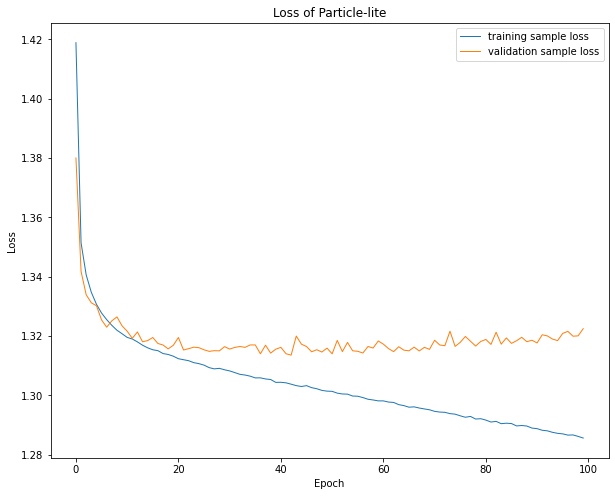

In [13]:
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], linewidth=1)
plt.plot(history.history['val_loss'], linewidth=1)
plt.title('Loss of Particle-lite')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['training sample loss','validation sample loss'])
plt.show()
plt.close()

In [14]:
def makeRoc(features_val, labels_val, labels, model, outputDir='', outputSuffix=''):
    from sklearn.metrics import roc_curve, auc
    labels_pred = model.predict(features_val)
    df = pd.DataFrame()
    fpr = {}
    tpr = {}
    auc1 = {}
    plt.figure(figsize=(10,8))
    for i, label in enumerate(labels):
        df[label] = labels_val[:,i]
        df[label + '_pred'] = labels_pred[:,i]
        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])
        auc1[label] = auc(fpr[label], tpr[label])
        plt.plot(fpr[label],tpr[label],label='%s tagger, AUC = %.1f%%'%(label.replace('j_',''),auc1[label]*100.))
    plt.plot([0, 1], [0, 1], lw=1, color='black', linestyle='--')
    #plt.semilogy()
    plt.xlabel("Background Efficiency")
    plt.ylabel("Signal Efficiency")
    plt.xlim([-0.05, 1.05])
    plt.ylim(0.001,1.05)
    plt.grid(True)
    plt.legend(loc='lower right')
    plt.figtext(0.25, 0.90,'particle net ROC Curve',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    #plt.figtext(0.35, 0.90,'preliminary', style='italic', wrap=True, horizontalalignment='center', fontsize=14) 
    #plt.savefig('%sROC_%s.pdf'%(outputDir, outputSuffix))
    return labels_pred

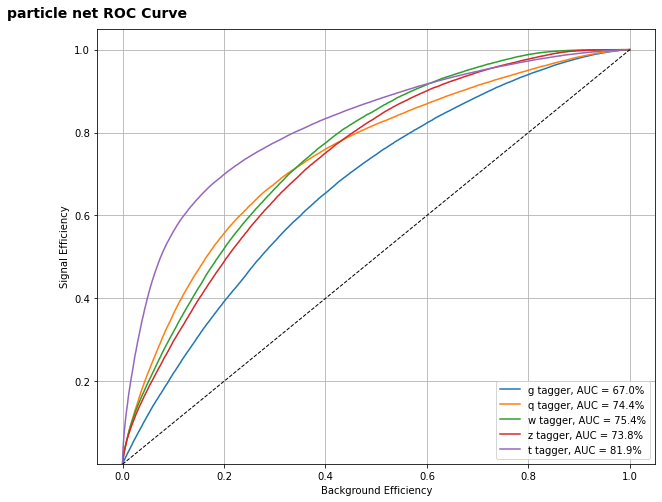

In [15]:
y_pred = makeRoc(X_test, y_test,labels, model, outputSuffix='particle net')